In [1]:
import pandas as pd
import numpy as np

from scipy.stats import spearmanr, rankdata
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import os
import shutil
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




# min_max_transform


# (START)table_to_image

#     generate_feature_distance_ranking

#     generate_matrix_distance_ranking    
 
#     IGTD

#         IGTD_absolute_error

#         IGTD_square_error

#     generate_image_data


In [44]:
cwd = os.getcwd()

data_path = "D:\\Research\\data\\processed_dataset" #lab

# tissue_type = 'liver'
# tissue_type = 'pancreas'
tissue_type = 'kidney'

df_main = pd.read_csv(f'{data_path}\\{tissue_type}\\highly_expressed_2500_genes.csv')
df_main = df_main.drop('Unnamed: 0',axis=1)

df_main

,0610005C13Rik,0610037P05Rik,1110059G10Rik,1190002H23Rik,1500004A13Rik,1500010J02Rik,1700016G22Rik,1700019L03Rik,1700034H15Rik,1700049G17Rik,...,Znf512b,Znhit3,Znrd1as,Znrf2,Zpbp,Zswim3,Zswim6,Zxdc,Zyx,Zzef1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,127,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,318,0,0,0,0,0,0,0,0,0,...,0,95,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
861,0,0,0,1424,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df = df_main.iloc[:,:].to_numpy()
# df = np.transpose(df)

df.shape

(865, 2500)

In [46]:
sc = StandardScaler()
 
# df = sc.fit_transform(df)

In [47]:
total_sample = df.shape[0]
total_feature = df.shape[1]

In [48]:
total_feature

2500

Functions

In [49]:
def gen_feat_dist_ranking(data):
    num = data.shape[1]
    corr = np.corrcoef(np.transpose(data))
    corr = 1 - corr
    corr = np.around(a=corr, decimals=10)
    
    tril_id = np.tril_indices(num)
    rank = rankdata(corr[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)
    
    return ranking, corr


In [50]:
def gen_matx_dist_ranking(num_r, num_c):

    # generate the coordinates of elements in a matrix
    for r in range(num_r):
        if r == 0:
            coordinate = np.transpose(np.vstack((np.zeros(num_c), range(num_c))))
        else:
            coordinate = np.vstack((coordinate, np.transpose(np.vstack((np.ones(num_c) * r, range(num_c))))))

    # calculate the closeness of the elements
    num = num_r * num_c
    cord_dist = np.zeros((num, num))

    for i in range(num):
        cord_dist[i, :] = np.sqrt(np.square(coordinate[i, 0] * np.ones(num) - coordinate[:, 0]) + np.square(coordinate[i, 1] * np.ones(num) - coordinate[:, 1]))


    # generate the ranking based on distance
    tril_id = np.tril_indices(num, k=-1)
    rank = rankdata(cord_dist[tril_id])
    ranking = np.zeros((num, num))
    ranking[tril_id] = rank
    ranking = ranking + np.transpose(ranking)

    coordinate = np.int64(coordinate)
    return (coordinate[:, 0], coordinate[:, 1]), ranking

In [51]:
def IGTD_absolute_error(source, target, max_step=1000, switch_t=0, val_step=50, min_gain=0.00001, random_state=1,
                        save_folder=None, file_name=''):
    '''
    This function switches the order of rows (columns) in the source ranking matrix to make it similar to the target
    ranking matrix. In each step, the algorithm randomly picks a row that has not been switched with others for
    the longest time and checks all possible switch of this row, and selects the switch that reduces the
    dissimilarity most. Dissimilarity (i.e. the error) is the summation of absolute difference of
    lower triangular elements between the rearranged source ranking matrix and the target ranking matrix.

    Input:
    source: a symmetric ranking matrix with zero diagonal elements.
    target: a symmetric ranking matrix with zero diagonal elements. 'source' and 'target' should have the same size.
    max_step: the maximum steps that the algorithm should run if never converges.
    switch_t: the threshold to determine whether switch should happen
    val_step: number of steps for checking gain on the objective function to determine convergence
    min_gain: if the objective function is not improved more than 'min_gain' in 'val_step' steps,
        the algorithm terminates.
    random_state: for setting random seed.
    save_folder: a path to save the picture of source ranking matrix in the optimization process.
    file_name: a string as part of the file names for saving results

    Return:
    index_record: indices to rearrange the rows(columns) in source obtained the optimization process
    err_record: error obtained in the optimization process
    run_time: the time at which each step is completed in the optimization process
    '''

    np.random.RandomState(seed=random_state)
    if os.path.exists(save_folder):
        shutil.rmtree(save_folder)
    os.mkdir(save_folder)

    source = source.copy()
    num = source.shape[0]
    tril_id = np.tril_indices(num, k=-1)
    index = np.array(range(num))
    index_record = np.empty((max_step + 1, num))
    index_record.fill(np.nan)
    index_record[0, :] = index.copy()

    # calculate the error associated with each row
    err_v = np.empty(num)
    err_v.fill(np.nan)
    for i in range(num):
        err_v[i] = np.sum(np.abs(source[i, 0:i] - target[i, 0:i])) + \
                   np.sum(np.abs(source[(i + 1):, i] - target[(i + 1):, i]))

    step_record = -np.ones(num)
    err_record = [np.sum(abs(source[tril_id] - target[tril_id]))]
    pre_err = err_record[0]
    t1 = time.time()
    run_time = [0]

    for s in range(max_step):
        delta = np.ones(num) * np.inf

        # randomly pick a row that has not been considered for the longest time
        idr = np.where(step_record == np.min(step_record))[0]
        ii = idr[np.random.permutation(len(idr))[0]]

        for jj in range(num):
            if jj == ii:
                continue

            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii

            err_ori = err_v[i] + err_v[j] - np.abs(source[j, i] - target[j, i])

            err_i = np.sum(np.abs(source[j, :i] - target[i, :i])) + \
                    np.sum(np.abs(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                    np.sum(np.abs(source[(j + 1):, j] - target[(j + 1):, i])) + np.abs(source[i, j] - target[j, i])
            err_j = np.sum(np.abs(source[i, :i] - target[j, :i])) + \
                    np.sum(np.abs(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                    np.sum(np.abs(source[(j + 1):, i] - target[(j + 1):, j])) + np.abs(source[i, j] - target[j, i])
            err_test = err_i + err_j - np.abs(source[i, j] - target[j, i])

            delta[jj] = err_test - err_ori

        delta_norm = delta / pre_err
        id = np.where(delta_norm <= switch_t)[0]
        if len(id) > 0:
            jj = np.argmin(delta)

            # Update the error associated with each row
            if ii < jj:
                i = ii
                j = jj
            else:
                i = jj
                j = ii
            for k in range(num):
                if k < i:
                    err_v[k] = err_v[k] - np.abs(source[i, k] - target[i, k]) - np.abs(source[j, k] - target[j, k]) + \
                               np.abs(source[j, k] - target[i, k]) + np.abs(source[i, k] - target[j, k])
                elif k == i:
                    err_v[k] = np.sum(np.abs(source[j, :i] - target[i, :i])) + \
                    np.sum(np.abs(source[(i + 1):j, j] - target[(i + 1):j, i])) + \
                    np.sum(np.abs(source[(j + 1):, j] - target[(j + 1):, i])) + np.abs(source[i, j] - target[j, i])
                elif k < j:
                    err_v[k] = err_v[k] - np.abs(source[k, i] - target[k, i]) - np.abs(source[j, k] - target[j, k]) + \
                               np.abs(source[k, j] - target[k, i]) + np.abs(source[i, k] - target[j, k])
                elif k == j:
                    err_v[k] = np.sum(np.abs(source[i, :i] - target[j, :i])) + \
                    np.sum(np.abs(source[i, (i + 1):j] - target[j, (i + 1):j])) + \
                    np.sum(np.abs(source[(j + 1):, i] - target[(j + 1):, j])) + np.abs(source[i, j] - target[j, i])
                else:
                    err_v[k] = err_v[k] - np.abs(source[k, i] - target[k, i]) - np.abs(source[k, j] - target[k, j]) + \
                               np.abs(source[k, j] - target[k, i]) + np.abs(source[k, i] - target[k, j])

            # switch rows i and j
            ii_v = source[ii, :].copy()
            jj_v = source[jj, :].copy()
            source[ii, :] = jj_v
            source[jj, :] = ii_v
            ii_v = source[:, ii].copy()
            jj_v = source[:, jj].copy()
            source[:, ii] = jj_v
            source[:, jj] = ii_v
            err = delta[jj] + pre_err

            # update rearrange index
            t = index[ii]
            index[ii] = index[jj]
            index[jj] = t

            # update step record
            step_record[ii] = s
            step_record[jj] = s
        else:
            # error is not changed due to no switch
            err = pre_err

            # update step record
            step_record[ii] = s

        err_record.append(err)
        print('Step ' + str(s) + ' err: ' + str(err))
        index_record[s + 1, :] = index.copy()
        run_time.append(time.time() - t1)

        if s > val_step:
            if np.sum((err_record[-val_step - 1] - np.array(err_record[(-val_step):])) / err_record[
                -val_step - 1] >= min_gain) == 0:
                break

        pre_err = err

    index_record = index_record[:len(err_record), :].astype(np.int)
    if save_folder is not None:
        pd.DataFrame(index_record).to_csv(save_folder + '/' + file_name + '_index.txt', header=False, index=False,
            sep='\t', line_terminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, np.array(range(s + 2))))),
            columns=['error', 'steps']).to_csv(save_folder + '/' + file_name + '_error_and_step.txt',
            header=True, index=False, sep='\t', line_terminator='\r\n')
        pd.DataFrame(np.transpose(np.vstack((err_record, run_time))), columns=['error', 'run_time']).to_csv(
            save_folder + '/' + file_name + '_error_and_time.txt', header=True, index=False, sep='\t',
            line_terminator='\r\n')

    return index_record, err_record, run_time

Implementation

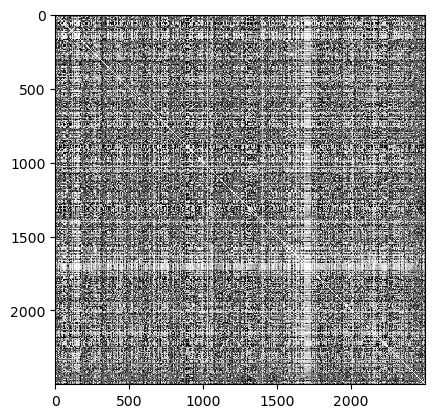

In [52]:
ranking_feature, corr = gen_feat_dist_ranking(df)
plt.imshow(np.max(ranking_feature) - ranking_feature, cmap='gray', interpolation='nearest')
plt.show()

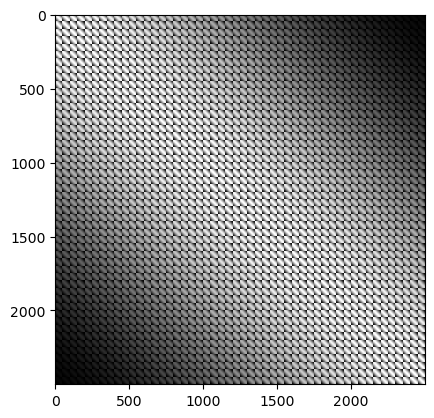

In [53]:
coordinate, ranking_image = gen_matx_dist_ranking(50,50)
# plt.imshow(ranking_image, cmap='gray')
plt.imshow(np.max(ranking_image) - ranking_image, cmap='gray', interpolation='nearest')
plt.show()

In [54]:
from IGTD_Functions import min_max_transform, table_to_image

In [55]:
num_row = 50    # Number of pixel rows in image representation
num_col = 50    # Number of pixel columns in image representation
num = num_row * num_col # Number of features to be included for analysis, which is also the total number of pixels in image representation
save_image_size = 3 # Size of pictures (in inches) saved during the execution of IGTD algorithm.
max_step = 10000    # The maximum number of iterations to run the IGTD algorithm, if it does not converge.
val_step = 300  # The number of iterations for determining algorithm convergence. If the error reduction rate
                # is smaller than a pre-set threshold for val_step itertions, the algorithm converges.

In [56]:

norm_data = min_max_transform(df_main.values)
norm_data = pd.DataFrame(norm_data, columns=df_main.columns, index=df_main.index)


In [57]:
# Run the IGTD algorithm using (1) the Euclidean distance for calculating pairwise feature distances and pariwise pixel
# distances and (2) the absolute function for evaluating the difference between the feature distance ranking matrix and
# the pixel distance ranking matrix. Save the result in Test_1 folder.
fea_dist_method = 'Euclidean'
image_dist_method = 'Euclidean'
error = 'abs'
result_dir = f'{data_path}\\{tissue_type}\\img'
os.makedirs(name=result_dir, exist_ok=True)
table_to_image(norm_data, [num_row, num_col], fea_dist_method, image_dist_method, save_image_size,
               max_step, val_step, result_dir, error)

Step 0 err: 3266879881554.0
Step 1 err: 3265824578821.0
Step 2 err: 3264123564551.0
Step 3 err: 3263110208660.0
Step 4 err: 3261711525543.0
Step 5 err: 3259776457081.0
Step 6 err: 3258569401316.0
Step 7 err: 3256404343345.0
Step 8 err: 3252988126556.0
Step 9 err: 3250735492863.0
Step 10 err: 3249895264626.0
Step 11 err: 3246864209298.0
Step 12 err: 3244241233731.0
Step 13 err: 3243195840754.0
Step 14 err: 3241999184569.0
Step 15 err: 3240955323643.0
Step 16 err: 3239764849945.0
Step 17 err: 3238991428106.0
Step 18 err: 3236313243037.0
Step 19 err: 3235283195802.0
Step 20 err: 3232832723658.0
Step 21 err: 3230296284272.0
Step 22 err: 3226831977044.0
Step 23 err: 3225763730963.0
Step 24 err: 3224154950650.0
Step 25 err: 3223113552266.0
Step 26 err: 3221214848176.0
Step 27 err: 3220299160688.0
Step 28 err: 3219230251641.0
Step 29 err: 3216997220093.0
Step 30 err: 3215531792398.0
Step 31 err: 3212987536789.0
Step 32 err: 3212192052328.0
Step 33 err: 3211660975143.0
Step 34 err: 32109059663